### Transfer Learning
(Author: Sasank Chilamkurthy)

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

torchvision.datasets.ImageFolder()可以自动读取图像并和相应的label对应好。数据集中的图像按照类别存放在不同的文件夹中，每个文件夹的名字就是类别的名称

In [2]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

data_dir = 'data/hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir,'train'),train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir,'val'),val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 4,shuffle =True, num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size = 4,shuffle = False, num_workers = 4)

train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)
class_names = train_dataset.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

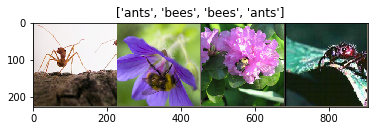

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
        
inputs, classes = next(iter(train_loader))
output = torchvision.utils.make_grid(inputs)
imshow(output, title = [class_names[x] for x in classes])

In [4]:
def train_model(model,train_loader,val_loader,criterion,optimizer,scheduler, num_epochs = 25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    model.train()
    
    for epoch in range(num_epochs):
        
        print('Epoch{}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)
        
        
        model = train(model,train_loader,criterion,optimizer,scheduler)
        model, epoch_acc= val(model,val_loader,criterion)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,time_elapsed % 60))
    print('Best val Acc:{:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def train(model,train_loader,criterion,optimizer,scheduler):
    model.train()
    scheduler.step()
    running_loss = 0.0
    running_corrects = 0
        
    for inputs,labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        optimizer.zero_grad()
            
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        loss =criterion(outputs,labels)
        loss.backward()
        optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / train_dataset_size
    epoch_acc = running_corrects.double() / train_dataset_size      
        
    print('Train Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
    return model

In [22]:
def val(model,val_loader,criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            loss =criterion(outputs,labels)
  

            running_loss +=loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / val_dataset_size
        epoch_acc = running_corrects.double() / val_dataset_size
        
        print('Val Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
            
        return model,epoch_acc
    

In [36]:
def visualize_model(model, num_images = 6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            print(outputs)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    return

In [24]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr = 0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [25]:
model_ft = train_model(model_ft,train_loader,val_loader,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch0/24
----------
Train Loss: 0.6909 Acc: 0.6967
Val Loss: 0.4503 Acc: 0.8301
Epoch1/24
----------
Train Loss: 0.6410 Acc: 0.7705
Val Loss: 0.1883 Acc: 0.9216
Epoch2/24
----------
Train Loss: 0.4371 Acc: 0.8156
Val Loss: 0.3228 Acc: 0.8562
Epoch3/24
----------
Train Loss: 0.3942 Acc: 0.8361
Val Loss: 0.3226 Acc: 0.8693
Epoch4/24
----------
Train Loss: 0.4688 Acc: 0.7869
Val Loss: 0.6871 Acc: 0.7190
Epoch5/24
----------
Train Loss: 0.4369 Acc: 0.8238
Val Loss: 0.3031 Acc: 0.8693
Epoch6/24
----------
Train Loss: 0.4141 Acc: 0.8279
Val Loss: 0.2525 Acc: 0.9281
Epoch7/24
----------
Train Loss: 0.2609 Acc: 0.8893
Val Loss: 0.2577 Acc: 0.9216
Epoch8/24
----------
Train Loss: 0.2485 Acc: 0.8811
Val Loss: 0.2714 Acc: 0.9216
Epoch9/24
----------
Train Loss: 0.2690 Acc: 0.8934
Val Loss: 0.2398 Acc: 0.9216
Epoch10/24
----------
Train Loss: 0.3346 Acc: 0.8525
Val Loss: 0.2303 Acc: 0.9216
Epoch11/24
----------
Train Loss: 0.2757 Acc: 0.8852
Val Loss: 0.2421 Acc: 0.9150
Epoch12/24
----------
Trai

tensor([[ 0.8111, -1.2022],
        [ 0.1032, -0.0942],
        [-0.2674, -1.8037],
        [ 1.0244, -1.8525]], device='cuda:0')


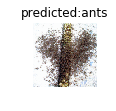

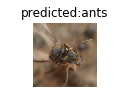

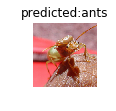

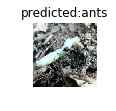

tensor([[ 2.0414, -4.1489],
        [ 2.0650, -2.8976],
        [-1.8903,  1.1372],
        [ 0.8286, -0.9838]], device='cuda:0')


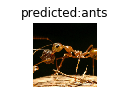

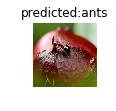

In [37]:
visualize_model(model_ft)

In [38]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,step_size =7,gamma =0.1)

In [40]:
model_conv = train_model(model_conv,train_loader,val_loader,criterion,optimizer_conv, exp_lr_scheduler,num_epochs = 25)

Epoch0/24
----------
Train Loss: 0.6160 Acc: 0.6434
Val Loss: 0.2066 Acc: 0.9281
Epoch1/24
----------
Train Loss: 0.4644 Acc: 0.8033
Val Loss: 0.2301 Acc: 0.9150
Epoch2/24
----------
Train Loss: 0.4204 Acc: 0.8361
Val Loss: 0.9226 Acc: 0.7124
Epoch3/24
----------
Train Loss: 0.5374 Acc: 0.7746
Val Loss: 0.1741 Acc: 0.9477
Epoch4/24
----------
Train Loss: 0.4700 Acc: 0.7992
Val Loss: 0.2065 Acc: 0.9085
Epoch5/24
----------
Train Loss: 0.4009 Acc: 0.8156
Val Loss: 0.2136 Acc: 0.9281
Epoch6/24
----------
Train Loss: 0.4779 Acc: 0.7992
Val Loss: 0.2381 Acc: 0.9085
Epoch7/24
----------
Train Loss: 0.3087 Acc: 0.8852
Val Loss: 0.1823 Acc: 0.9412
Epoch8/24
----------
Train Loss: 0.3769 Acc: 0.8033
Val Loss: 0.1941 Acc: 0.9412
Epoch9/24
----------
Train Loss: 0.4333 Acc: 0.8361
Val Loss: 0.1834 Acc: 0.9412
Epoch10/24
----------
Train Loss: 0.3354 Acc: 0.8320
Val Loss: 0.1737 Acc: 0.9477
Epoch11/24
----------
Train Loss: 0.3799 Acc: 0.8279
Val Loss: 0.1795 Acc: 0.9412
Epoch12/24
----------
Trai

tensor([[ 1.5267, -0.4639],
        [ 2.8929, -1.7342],
        [ 1.8420, -0.8213],
        [ 1.8726, -1.7038]], device='cuda:0')


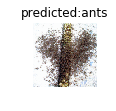

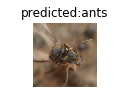

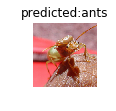

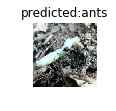

tensor([[ 3.5635, -3.0275],
        [ 3.6334, -2.2941],
        [-1.5730,  3.2610],
        [ 2.0374, -0.7111]], device='cuda:0')


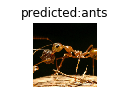

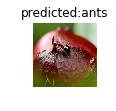

In [41]:
visualize_model(model_conv)
plt.ioff()
plt.show()